In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
cd /content/drive/MyDrive/Colab Notebooks/ML/projects/natural-gas/

/content/drive/MyDrive/Colab Notebooks/ML/projects/natural-gas


# **Loading data**

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [88]:
df=pd.read_csv('processed_nasdaq.csv', index_col="Date", parse_dates=True)
df = df.drop(["vol"], axis=1)
seasons = {"Spring": 1,
           "Summer": 2,
           "Autumn": 3,
           "Winter": 4}
df["season"] = df.season.map(seasons)
df = df[::-1]
df.head(10)

,close,open,high,low,season
Date,,,,,
2012-05-02,2.253,2.371,2.384,2.236,1
2012-05-03,2.340,2.260,2.379,2.253,1
2012-05-04,2.279,2.340,2.373,2.265,1
2012-05-07,2.336,2.277,2.358,2.273,1
2012-05-08,2.393,2.323,2.460,2.280,1
2012-05-09,2.465,2.440,2.509,2.403,1
2012-05-10,2.487,2.463,2.519,2.407,1
2012-05-11,2.509,2.467,2.529,2.456,1
2012-05-14,2.431,2.502,2.517,2.414,1


In [89]:
df.head(100)

,close,open,high,low,season
Date,,,,,
2012-05-02,2.253,2.371,2.384,2.236,1
2012-05-03,2.340,2.260,2.379,2.253,1
2012-05-04,2.279,2.340,2.373,2.265,1
2012-05-07,2.336,2.277,2.358,2.273,1
2012-05-08,2.393,2.323,2.460,2.280,1
...,...,...,...,...,...
2012-09-12,3.063,3.001,3.068,2.950,3
2012-09-13,3.037,3.063,3.070,2.960,3
2012-09-14,2.943,3.036,3.062,2.920,3


In [90]:
df.isnull().sum()

close     0
open      0
high      0
low       0
season    0
dtype: int64

# **Visualizing Data**

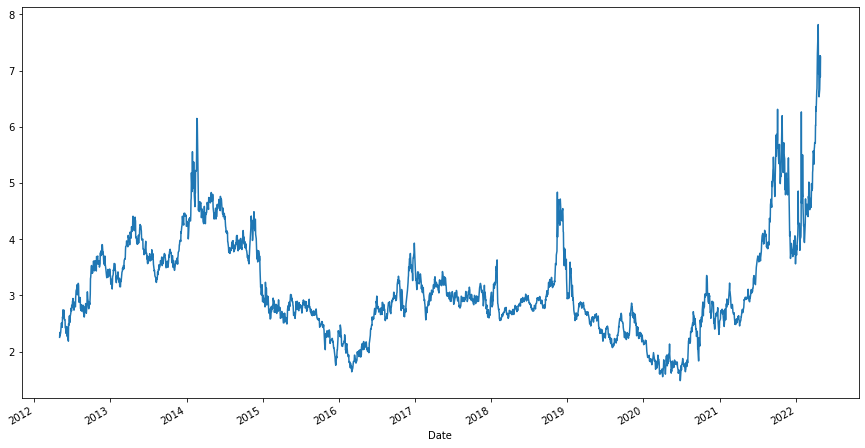

In [91]:
df.close.plot(figsize=(15, 8))

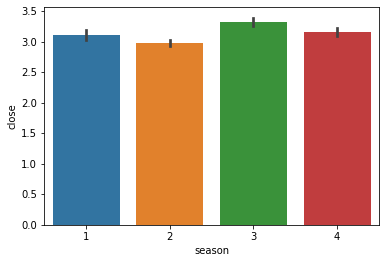

In [92]:
sns.barplot(x=df.season, y=df.close)

# **Testing for stationarity**

In [93]:
from statsmodels.tsa.stattools import adfuller

In [94]:
test_result = adfuller(df.close)
test_result

(-1.1254284083043977,
 0.7048255697947898,
 23,
 2527,
 {'1%': -3.4329404056582598,
  '5%': -2.862684432835292,
  '10%': -2.567379225007826},
 -3520.3710788389735)

In [95]:
#Ho: It is not stationary
#H1: It is stationary

def adfuller_test(price):
    result = adfuller(price)
    labels = ["ADF Test statistic", "pi value", "#Lags used", "Number of observations used"]
    for value, label in zip(result, labels):
        print(label+ " : " + str(value))
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary")

In [96]:
adfuller_test(df.close)

ADF Test statistic : -1.1254284083043977
pi value : 0.7048255697947898
#Lags used : 23
Number of observations used : 2527
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary


# **Differencing**

In [97]:
df["close_first_difference"] = df["close"] - df["close"].shift(1)

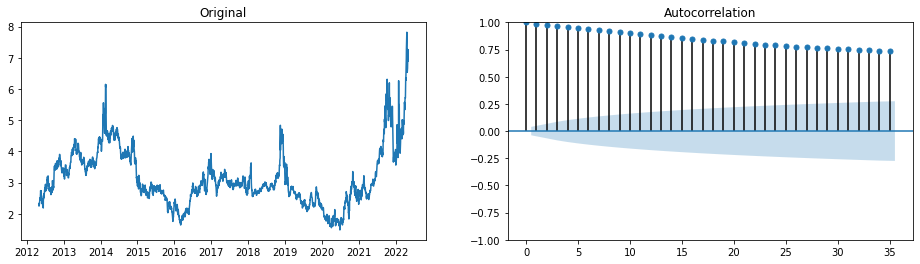

In [98]:
# autocorrelation function
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(df.close)
ax1.set_title("Original")
plot_acf(df.close, ax=ax2);

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


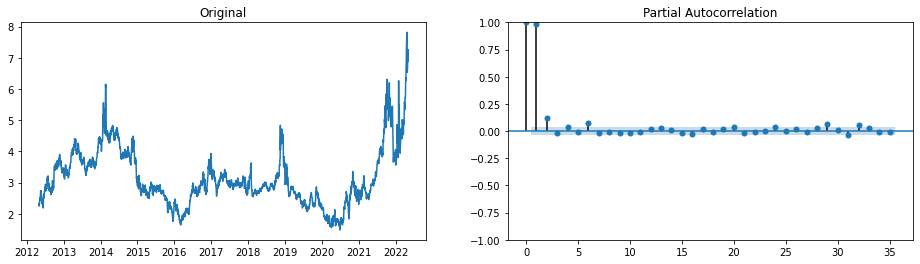

In [99]:
# autocorrelation function
from statsmodels.graphics.tsaplots import plot_pacf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(df.close)
ax1.set_title("Original")
plot_pacf(df.close, ax=ax2);

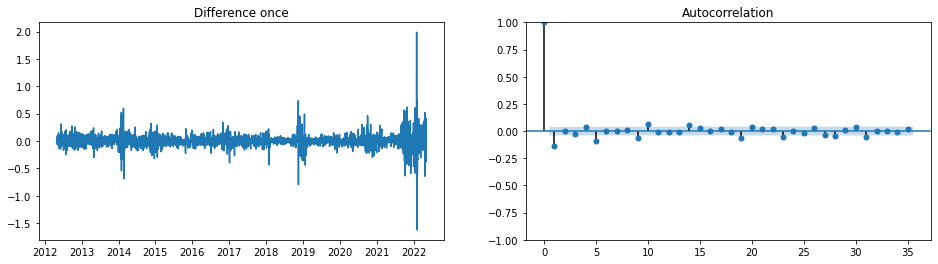

In [100]:
diff = df.close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax=ax2);

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


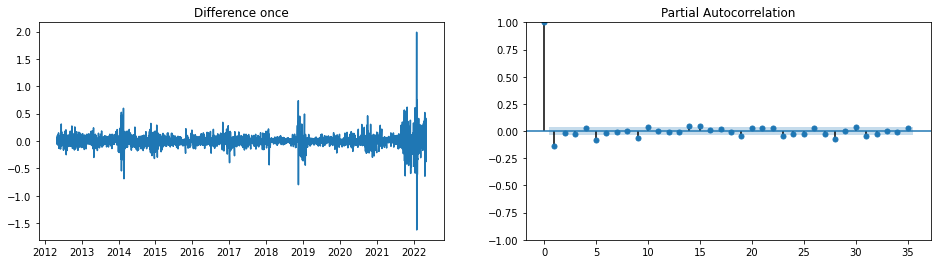

In [101]:
diff = df.close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title("Difference once")
plot_pacf(diff, ax=ax2);

**we can also use the pmdarima package to get the number of differencing**

In [102]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Finding the value for d using pmdarima**

In [103]:
from pmdarima.arima.utils import ndiffs
ndiffs(df.close, test="adf")

1

So we got the d value, 

# **now we have to choose our p value**

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


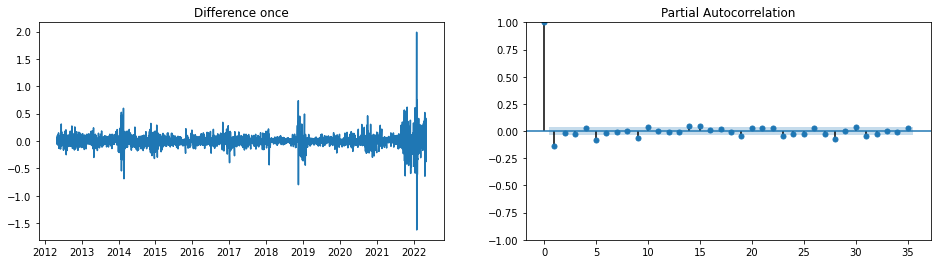

In [104]:
from statsmodels.graphics.tsaplots import plot_pacf
diff = df.close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2);

The 4th point is slightly above the line, so set p=4

# **Now we have to find the value for q**

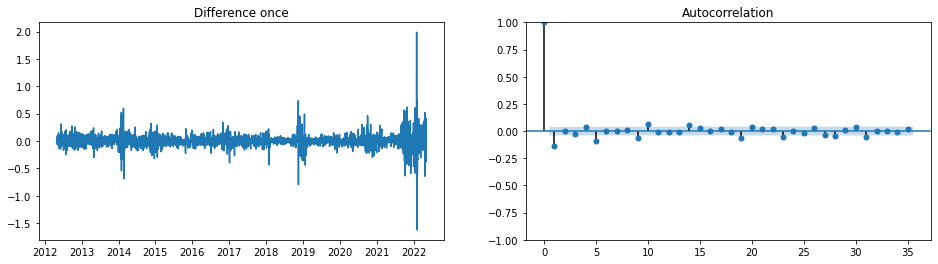

In [105]:
diff = df.close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2);

Again the 4th point is slightly above the line, so set q=4

# ACF and PACF using seasonal differencing

In [106]:
# there are price for 19 days in a month. And we have a seasonality of 12 months
df["seasonal_first_difference"] = df["close"] - df["close"].shift(12)

In [107]:
df.head(40)

,close,open,high,low,season,close_first_difference,seasonal_first_difference
Date,,,,,,,
2012-05-02,2.253,2.371,2.384,2.236,1,NaN,NaN
2012-05-03,2.340,2.260,2.379,2.253,1,0.087,NaN
2012-05-04,2.279,2.340,2.373,2.265,1,-0.061,NaN
2012-05-07,2.336,2.277,2.358,2.273,1,0.057,NaN
2012-05-08,2.393,2.323,2.460,2.280,1,0.057,NaN
2012-05-09,2.465,2.440,2.509,2.403,1,0.072,NaN
2012-05-10,2.487,2.463,2.519,2.407,1,0.022,NaN
2012-05-11,2.509,2.467,2.529,2.456,1,0.022,NaN
2012-05-14,2.431,2.502,2.517,2.414,1,-0.078,NaN


In [108]:
df.dropna()

,close,open,high,low,season,close_first_difference,seasonal_first_difference
Date,,,,,,,
2012-05-18,2.742,2.633,2.759,2.606,1,0.148,0.489
2012-05-21,2.609,2.722,2.743,2.589,1,-0.133,0.269
2012-05-22,2.707,2.642,2.727,2.579,1,0.098,0.428
2012-05-23,2.737,2.691,2.746,2.615,1,0.030,0.401
2012-05-24,2.647,2.729,2.750,2.628,1,-0.090,0.254
...,...,...,...,...,...,...,...
2022-04-25,6.669,6.414,6.966,6.345,1,0.135,0.640
2022-04-26,6.850,6.836,7.050,6.662,1,0.181,0.491
2022-04-27,7.267,6.858,7.344,6.800,1,0.417,0.989


In [109]:
adfuller_test(df.seasonal_first_difference.dropna())

ADF Test statistic : -7.831059984533748
pi value : 6.2913505101973745e-12
#Lags used : 26
Number of observations used : 2512
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


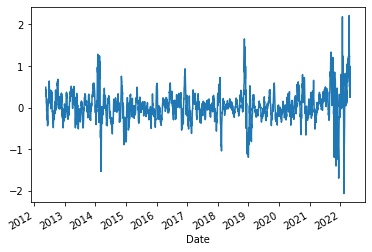

In [110]:
df.seasonal_first_difference.plot()

**p, d, q**

**p - AR model lags**
**d - differencing**
**q - MA model lags**

In [111]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


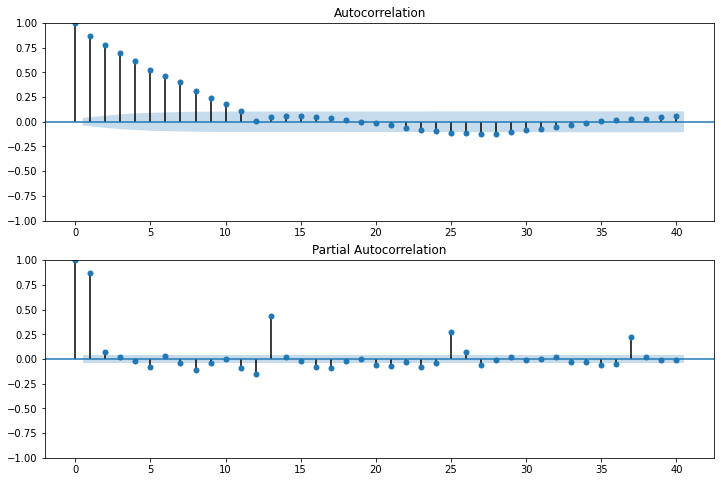

In [112]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df.seasonal_first_difference.dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df.seasonal_first_difference.dropna(), lags=40, ax=ax2)

ar - 2(pac)
ma = 5(ac) 

# **Final ARIMA**

In [113]:
adfuller_test(df.close_first_difference.dropna())

ADF Test statistic : -10.159599979846758
pi value : 7.569132503743969e-18
#Lags used : 27
Number of observations used : 2522
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


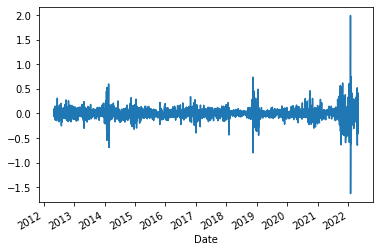

In [114]:
df.close_first_difference.plot()

In [115]:
x = df.close.dropna()

In [116]:
# for non-seasonal data
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [117]:
model = sm.tsa.arima.ARIMA(x, order=(4, 1, 4))
model_fit = model.fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [118]:
df.shape

(2551, 7)

In [119]:
import pickle
with open('arima_nasdaq.pkl', 'wb') as f:
    pickle.dump(model_fit, f)

In [120]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 2551
Model:                 ARIMA(4, 1, 4)   Log Likelihood                1795.523
Date:                Fri, 13 Jan 2023   AIC                          -3573.047
Time:                        11:38:42   BIC                          -3520.452
Sample:                             0   HQIC                         -3553.971
                               - 2551                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4920      0.098     -5.010      0.000      -0.684      -0.300
ar.L2         -0.3526      0.098     -3.593      0.000      -0.545      -0.160
ar.L3          0.0115      0.103      0.112      0.911      -0.190       0.213
ar.L4          0.5938      0.058     10.253      0.000       0.480       0.707
ma.L1          0.3586      0.099      3.622      0.000       0.165       0.553
ma.L2          0.2800      0.086      3.271      0.001       0.112       0.448
ma.L3         -0.0874      0.092     -0.953      0.341      -0.267       0.092
ma.L4         -0.5906      0.049    -11.981      0.000      -0.687      -0.494
sigma2         0.0143      0.000    120.471      0.000       0.014       0.015
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            158656.46
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.34   Skew:                             1.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        41.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [121]:
df.shape

(2551, 7)

In [122]:
2551 - 2551*0.2

2040.8

In [123]:
start = 2041
end = 2550

In [124]:
df.close[2041:]

Date
2020-04-23    1.815
2020-04-24    1.746
2020-04-27    1.819
2020-04-28    1.794
2020-04-29    1.869
              ...  
2022-04-25    6.669
2022-04-26    6.850
2022-04-27    7.267
2022-04-28    6.888
2022-04-29    7.244
Name: close, Length: 510, dtype: float64

In [125]:
forecast = model_fit.predict(start=start, end=end, dynamic=False)
df["forecast"] = forecast

In [126]:
forecast.shape

(510,)

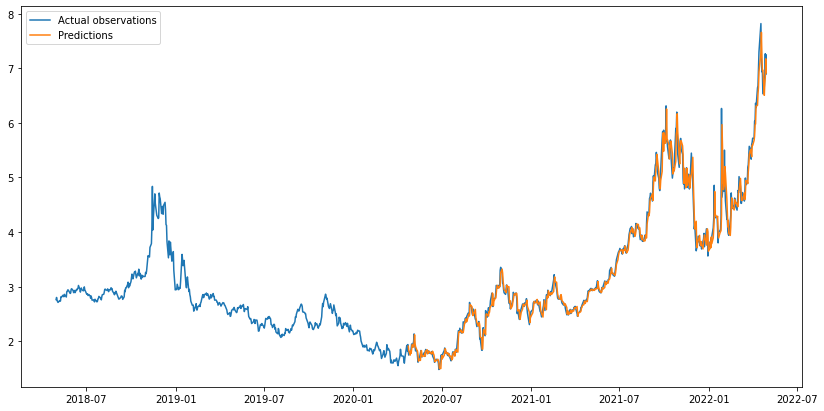

In [127]:
plt.figure(figsize=(14, 7))
plt.plot(df.close[start-500:], label="Actual observations")
plt.plot(df.forecast, label="Predictions")
plt.legend()
plt.show()

# **Accuracy**

In [128]:
from sklearn.metrics import *
from math import sqrt

MSE = mean_squared_error(df.iloc[start:, 0], df.iloc[start:, 7])
R2 = r2_score(df.iloc[start:, 0], df.iloc[start:, 7])
RMSE = sqrt(mean_squared_error(df.iloc[start:, 0], df.iloc[start:, 7]))
MAE = mean_absolute_error(df.iloc[start:, 0], df.iloc[start:, 7])
MAPE = mean_absolute_percentage_error(df.iloc[start:, 0], df.iloc[start:, 7]) 


from tabulate import tabulate
results= [["ARIMA with NASDAQ DATASET",MSE,R2,RMSE,MAE,MAPE]]
col_names = ["Model/Metrics", "MSE","R-Squared","RMSE","MAE","MAPE"]
print(tabulate(results,headers=col_names,tablefmt="fancy_grid"))

╒═══════════════════════════╤══════════╤═════════════╤══════════╤══════════╤═════════╕
│ Model/Metrics             │      MSE │   R-Squared │     RMSE │      MAE │    MAPE │
╞═══════════════════════════╪══════════╪═════════════╪══════════╪══════════╪═════════╡
│ ARIMA with NASDAQ DATASET │ 0.036708 │     0.97903 │ 0.191593 │ 0.115319 │ 0.03143 │
╘═══════════════════════════╧══════════╧═════════════╧══════════╧══════════╧═════════╛


# **LSTM**

### Preparing the data for training the model

In [129]:

# univariate lstm example
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns


In [130]:
data = pd.read_csv("processed_nasdaq.csv", index_col="Date", parse_dates=True)
data = data[::-1]

In [131]:
data

,close,vol,open,high,low,season
Date,,,,,,
2012-05-02,2.253,153675.0,2.371,2.384,2.236,Spring
2012-05-03,2.340,152267.0,2.260,2.379,2.253,Spring
2012-05-04,2.279,112541.0,2.340,2.373,2.265,Spring
2012-05-07,2.336,84553.0,2.277,2.358,2.273,Spring
2012-05-08,2.393,147686.0,2.323,2.460,2.280,Spring
...,...,...,...,...,...,...
2022-04-25,6.669,29612.0,6.414,6.966,6.345,Spring
2022-04-26,6.850,31569.0,6.836,7.050,6.662,Spring
2022-04-27,7.267,2630.0,6.858,7.344,6.800,Spring


In [132]:
cols = ["close", "open", "high", "low"]
new_data = data[cols].astype(float)
new_data

,close,open,high,low
Date,,,,
2012-05-02,2.253,2.371,2.384,2.236
2012-05-03,2.340,2.260,2.379,2.253
2012-05-04,2.279,2.340,2.373,2.265
2012-05-07,2.336,2.277,2.358,2.273
2012-05-08,2.393,2.323,2.460,2.280
...,...,...,...,...
2022-04-25,6.669,6.414,6.966,6.345
2022-04-26,6.850,6.836,7.050,6.662
2022-04-27,7.267,6.858,7.344,6.800


In [133]:
new_data.isnull().sum()

close    0
open     0
high     0
low      0
dtype: int64

In [134]:
scaler = StandardScaler()
scaler = scaler.fit(new_data)
scaled_data = scaler.transform(new_data)

In [135]:
scaled_data 

array([[-0.98920895, -0.86240869, -0.88456226, -0.97145537],
       [-0.89227485, -0.98674779, -0.88994276, -0.9518697 ],
       [-0.96024014, -0.89713402, -0.89639935, -0.93804452],
       ...,
       [ 4.59731486,  4.16380353,  4.45288639,  4.28672046],
       [ 4.17503873,  4.76533595,  4.53682207,  4.37773621],
       [ 4.57168861,  4.25453747,  4.4432015 ,  4.29248095]])

In [136]:
trainX = []
trainy = []

n_future = 1
n_past = 14

In [137]:
scaled_data.shape

(2551, 4)

In [138]:
for i in range(0, len(scaled_data)-n_past):
    trainX.append(scaled_data[i: i+n_past, :])
    trainy.append(scaled_data[i+n_past: n_past+n_future+i, 0])


trainX, trainy = np.array(trainX), np.array(trainy)

In [139]:
trainX

array([[[-0.98920895, -0.86240869, -0.88456226, -0.97145537],
        [-0.89227485, -0.98674779, -0.88994276, -0.9518697 ],
        [-0.96024014, -0.89713402, -0.89639935, -0.93804452],
        ...,
        [-0.60927185, -0.57788497, -0.57249369, -0.65808468],
        [-0.44437246, -0.5689236 , -0.48102532, -0.54517906],
        [-0.59255907, -0.46922828, -0.49824289, -0.56476473]],

       [[-0.89227485, -0.98674779, -0.88994276, -0.9518697 ],
        [-0.96024014, -0.89713402, -0.89639935, -0.93804452],
        [-0.89673159, -0.96770487, -0.91254082, -0.92882774],
        ...,
        [-0.44437246, -0.5689236 , -0.48102532, -0.54517906],
        [-0.59255907, -0.46922828, -0.49824289, -0.56476473],
        [-0.48336894, -0.55884205, -0.51546047, -0.57628571]],

       [[-0.96024014, -0.89713402, -0.89639935, -0.93804452],
        [-0.89673159, -0.96770487, -0.91254082, -0.92882774],
        [-0.83322304, -0.91617695, -0.80277878, -0.92076305],
        ...,
        [-0.59255907, -0.46

In [140]:
trainy

array([[-0.48336894],
       [-0.44994339],
       [-0.55022004],
       ...,
       [ 4.59731486],
       [ 4.17503873],
       [ 4.57168861]])

In [141]:
trainX.shape

(2537, 14, 4)

In [142]:
trainy.shape

(2537, 1)

### Building LSTM Model

relu - rectified linear activation function - to allow the neural network to learn nonlinear dependencies

mse - mean squared error for the regression values

In [143]:
import keras
# define model
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(LSTM(32, activation='relu', return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(trainy.shape[1]))
model.compile(optimizer='adam', loss='mae', metrics=keras.metrics.MeanAbsoluteError())
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 14, 64)            17664     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________


In [144]:
# fit model
history = model.fit(trainX, trainy, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/100
143/143 [==============================] - 11s 42ms/step - loss: 0.2339 - mean_absolute_error: 0.2339 - val_loss: 0.3077 - val_mean_absolute_error: 0.3077
Epoch 2/100
143/143 [==============================] - 5s 35ms/step - loss: 0.1704 - mean_absolute_error: 0.1704 - val_loss: 0.3466 - val_mean_absolute_error: 0.3466
Epoch 3/100
143/143 [==============================] - 7s 47ms/step - loss: 0.1564 - mean_absolute_error: 0.1564 - val_loss: 0.2866 - val_mean_absolute_error: 0.2866
Epoch 4/100
143/143 [==============================] - 5s 37ms/step - loss: 0.1526 - mean_absolute_error: 0.1526 - val_loss: 0.2734 - val_mean_absolute_error: 0.2734
Epoch 5/100
143/143 [==============================] - 5s 37ms/step - loss: 0.1487 - mean_absolute_error: 0.1487 - val_loss: 0.2647 - val_mean_absolute_error: 0.2647
Epoch 6/100
143/143 [==============================] - 5s 34ms/step - loss: 0.1434 - mean_absolute_error: 0.1434 - val_loss: 0.3102 - val_mean_absolute_error: 0.3102
Epo

In [145]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

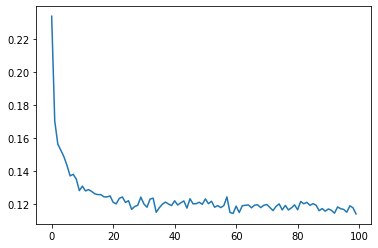

In [146]:
plt.plot(history.history['loss'])

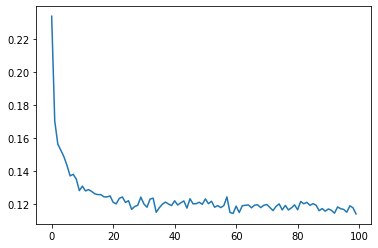

In [147]:
plt.plot(history.history['mean_absolute_error'])

### Predicting

In [148]:
new_data.close.shape[0]*0.2

510.20000000000005

In [149]:
2551 - 510

2041

In [150]:
start = 2041

In [151]:
forecast = model.predict(trainX[start-14:])

16/16 [==============================] - 0s 6ms/step


In [152]:
forecast.shape

(510, 1)

In [153]:
forecast_copies = np.repeat(forecast, new_data.shape[1], axis=1)
y_pred = scaler.inverse_transform(forecast_copies)[:, 0]
y_pred

array([1.9850111, 1.8030809, 1.765157 , 1.8264477, 1.8100698, 1.9549168,
       1.9584985, 1.9136239, 2.0420005, 2.1627264, 1.9236687, 1.9315529,
       1.8404306, 1.8669013, 1.7201389, 1.641554 , 1.7429641, 1.6736685,
       1.8822348, 1.8392462, 1.7956622, 1.7229664, 1.7725872, 1.8215387,
       1.7323902, 1.9254048, 1.8465908, 1.7803882, 1.8143893, 1.8616227,
       1.839531 , 1.8126882, 1.8130035, 1.8006673, 1.7902207, 1.8477249,
       1.7415977, 1.7023323, 1.63875  , 1.686468 , 1.6685851, 1.7162668,
       1.6973674, 1.6574761, 1.633886 , 1.4826063, 1.5793934, 1.8146292,
       1.7562946, 1.6885005, 1.8153929, 1.866348 , 1.9074904, 1.8288422,
       1.8210732, 1.8238152, 1.7513775, 1.7825398, 1.808374 , 1.7406094,
       1.751877 , 1.641831 , 1.7266877, 1.6983758, 1.8458425, 1.8119215,
       1.7446775, 1.8431232, 1.8797796, 1.8588747, 1.8257896, 2.1957984,
       2.166149 , 2.2229006, 2.1941986, 2.253025 , 2.1607835, 2.2052941,
       2.1435878, 2.2081876, 2.3906305, 2.343989 , 

### Visualizaing The Output

In [154]:
y_pred.shape

(510,)

In [155]:
new_data.iloc[start:, 0].shape

(510,)

In [156]:
x = new_data.iloc[start:, 0].values

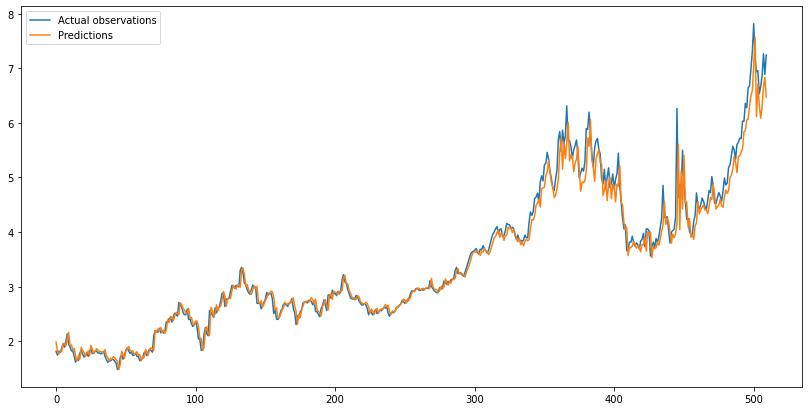

In [157]:
plt.figure(figsize=(14, 7))
plt.plot(x, label="Actual observations")
plt.plot(y_pred, label="Predictions")
plt.legend()
plt.show()

# **Accuracy**

In [158]:
from sklearn.metrics import *
from math import sqrt

MSE = mean_squared_error(x, y_pred)
R2 = r2_score(x, y_pred)
RMSE = sqrt(mean_squared_error(x, y_pred))
MAE = mean_absolute_error(x, y_pred)
MAPE = mean_absolute_percentage_error(x, y_pred)


from tabulate import tabulate
results= [["LSTM With NASDAQ DATASET",MSE,R2,RMSE,MAE,MAPE]]
col_names = ["Model/Metrics", "MSE","R-Squared","RMSE","MAE","MAPE"]  
print(tabulate(results,headers=col_names,tablefmt="fancy_grid"))

╒══════════════════════════╤══════════╤═════════════╤══════════╤══════════╤═══════════╕
│ Model/Metrics            │      MSE │   R-Squared │     RMSE │      MAE │      MAPE │
╞══════════════════════════╪══════════╪═════════════╪══════════╪══════════╪═══════════╡
│ LSTM With NASDAQ DATASET │ 0.052988 │     0.96973 │ 0.230191 │ 0.137344 │ 0.0354421 │
╘══════════════════════════╧══════════╧═════════════╧══════════╧══════════╧═══════════╛


# **Hybrid result**

In [159]:
from sklearn.metrics import *
from math import sqrt

MSE = mean_squared_error(df.iloc[start:, 0], df.iloc[start:, 7])
R2 = r2_score(df.iloc[start:, 0], df.iloc[start:, 7])
RMSE = sqrt(mean_squared_error(df.iloc[start:, 0], df.iloc[start:, 7]))
MAE = mean_absolute_error(df.iloc[start:, 0], df.iloc[start:, 7])
MAPE = mean_absolute_percentage_error(df.iloc[start:, 0], df.iloc[start:, 7]) 


from tabulate import tabulate
results= [["ARIMA with NASDAQ DATASET",MSE,R2,RMSE,MAE,MAPE]]
col_names = ["Model/Metrics", "MSE","R-Squared","RMSE","MAE","MAPE"]
print(tabulate(results,headers=col_names,tablefmt="fancy_grid"))

╒═══════════════════════════╤══════════╤═════════════╤══════════╤══════════╤═════════╕
│ Model/Metrics             │      MSE │   R-Squared │     RMSE │      MAE │    MAPE │
╞═══════════════════════════╪══════════╪═════════════╪══════════╪══════════╪═════════╡
│ ARIMA with NASDAQ DATASET │ 0.036708 │     0.97903 │ 0.191593 │ 0.115319 │ 0.03143 │
╘═══════════════════════════╧══════════╧═════════════╧══════════╧══════════╧═════════╛


In [160]:
hybrid_df = pd.DataFrame({"Arima_y": df.iloc[start:, 7]})
hybrid_df

,Arima_y
Date,
2020-04-23,1.910429
2020-04-24,1.832780
2020-04-27,1.745635
2020-04-28,1.823000
2020-04-29,1.780217
...,...
2022-04-25,6.505300
2022-04-26,6.728603
2022-04-27,6.850546


In [161]:
hybrid_df["Lstm_y"] = y_pred
hybrid_df

,Arima_y,Lstm_y
Date,,
2020-04-23,1.910429,1.985011
2020-04-24,1.832780,1.803081
2020-04-27,1.745635,1.765157
2020-04-28,1.823000,1.826448
2020-04-29,1.780217,1.810070
...,...,...
2022-04-25,6.505300,6.086594
2022-04-26,6.728603,6.285245
2022-04-27,6.850546,6.668184


In [162]:
hybrid_df["X"] = x
hybrid_df

,Arima_y,Lstm_y,X
Date,,,
2020-04-23,1.910429,1.985011,1.815
2020-04-24,1.832780,1.803081,1.746
2020-04-27,1.745635,1.765157,1.819
2020-04-28,1.823000,1.826448,1.794
2020-04-29,1.780217,1.810070,1.869
...,...,...,...
2022-04-25,6.505300,6.086594,6.669
2022-04-26,6.728603,6.285245,6.850
2022-04-27,6.850546,6.668184,7.267


In [163]:
hybrid_df["Mean"] = hybrid_df[["Arima_y", "Lstm_y"]].mean(axis=1)
hybrid_df

,Arima_y,Lstm_y,X,Mean
Date,,,,
2020-04-23,1.910429,1.985011,1.815,1.947720
2020-04-24,1.832780,1.803081,1.746,1.817930
2020-04-27,1.745635,1.765157,1.819,1.755396
2020-04-28,1.823000,1.826448,1.794,1.824724
2020-04-29,1.780217,1.810070,1.869,1.795143
...,...,...,...,...
2022-04-25,6.505300,6.086594,6.669,6.295947
2022-04-26,6.728603,6.285245,6.850,6.506924
2022-04-27,6.850546,6.668184,7.267,6.759365


In [173]:
dummy_df = pd.DataFrame()

In [174]:
dummy_df[['Arima', 'RNN', 'GRU', 'Proposed']] = hybrid_df

In [164]:
from sklearn.metrics import *
from math import sqrt

MSE = mean_squared_error(hybrid_df.iloc[:, 2], hybrid_df.iloc[:, 3])
R2 = r2_score(hybrid_df.iloc[:, 2], hybrid_df.iloc[:, 3])
RMSE = sqrt(mean_squared_error(hybrid_df.iloc[:, 2], hybrid_df.iloc[:, 3]))
MAE = mean_absolute_error(hybrid_df.iloc[:, 2], hybrid_df.iloc[:, 3])
MAPE = mean_absolute_percentage_error(hybrid_df.iloc[:, 2], hybrid_df.iloc[:, 3]) 


from tabulate import tabulate
results= [["ARIMA with NASDAQ DATASET",MSE,R2,RMSE,MAE,MAPE]]
col_names = ["Model/Metrics", "MSE","R-Squared","RMSE","MAE","MAPE"]
print(tabulate(results,headers=col_names,tablefmt="fancy_grid"))

╒═══════════════════════════╤═══════════╤═════════════╤══════════╤══════════╤═══════════╕
│ Model/Metrics             │       MSE │   R-Squared │     RMSE │      MAE │      MAPE │
╞═══════════════════════════╪═══════════╪═════════════╪══════════╪══════════╪═══════════╡
│ ARIMA with NASDAQ DATASET │ 0.0404045 │    0.976918 │ 0.201009 │ 0.120576 │ 0.0320433 │
╘═══════════════════════════╧═══════════╧═════════════╧══════════╧══════════╧═══════════╛


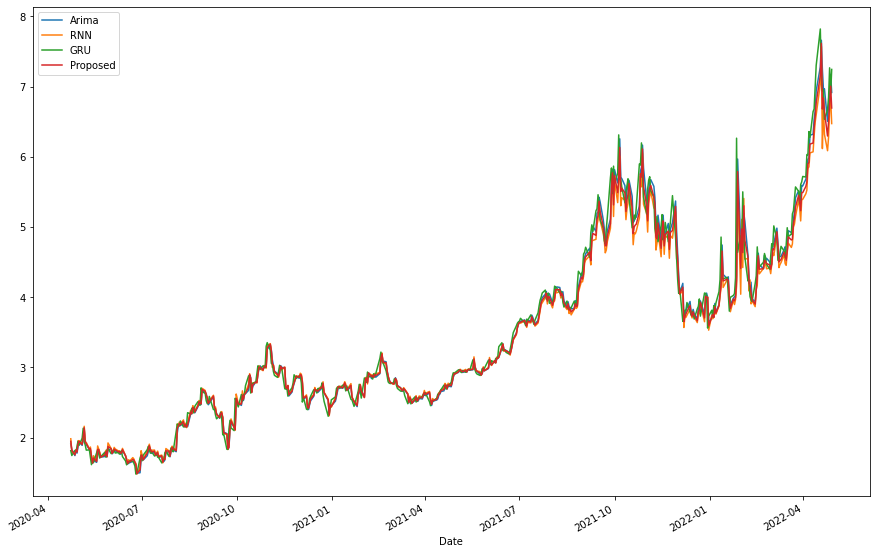

In [178]:
dummy_df.plot(figsize=(15, 10))